# ResNet50v2 trained on ImageNet-1K

## Install Dependencies

In [1]:
!pip install albumentations --quiet
!pip install torchsummary --quiet
!pip install tqdm --quiet
!pip install matplotlib --quiet
!pip install torch-lr-finder --quiet
!pip install grad-cam --quiet

## Import Modules

In [2]:
# Standard Library Imports
from collections import OrderedDict

# Third Party Imports
import matplotlib.pyplot as plt
import torch
import torchsummary
import torch.nn as nn
import torch.optim as optim
from torch.cuda.amp import autocast, GradScaler
from torch_lr_finder import LRFinder

# Local Imports
from datamodule.dataloader import ImageNetDataLoader
from datamodule.augmentations import ImageNetAugmentations
from model.resnets import ResNet50
from train.training_utils import get_lr, train, test, save_checkpoint
from configs.config import TrainingConfig, ModelConfig, DataConfig
from configs.aws_setup import setup_training_environment
from utils.visualize import display_loss_and_accuracies

/opt/conda/envs/pytorch/lib/python3.11/site-packages/torch_lr_finder/lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## Training Configuration

In [3]:
# Setup training environment and get configuration
config, train_params = setup_training_environment(debug=True)

# Initialize configuration
training_config = TrainingConfig()
model_config = ModelConfig()
data_config = DataConfig()

# Update training parameters based on EC2 optimization
training_config.batch_size = train_params['batch_size']
training_config.num_workers = train_params['num_workers']
training_config.gradient_accumulation_steps = config.gradient_accumulation_steps

# Device configuration
device = 'cuda' if torch.cuda.is_available() else 'cpu'

GPU Information:
{'gpu_count': 1, 'gpu_name': 'Tesla T4', 'cuda_version': '12.4'}

Training Parameters:
{'batch_size': 128, 'effective_batch_size': 512, 'num_workers': 4, 'pin_memory': True, 'prefetch_factor': 2}

Initial GPU Usage:
Sun Dec 29 11:19:49 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.127.05             Driver Version: 550.127.05     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       On  |   00000000:00:1E.0 Off |                    0 |

## Augmentations

Augmentation to be applied during training on ImageNet-1K training dataset

In [4]:
augmentations = ImageNetAugmentations()

## DataLoaders

In [5]:
# Create training loader
train_loader = ImageNetDataLoader(
    beton_path=data_config.train_path,
    mode='train',
    batch_size=training_config.batch_size,
    num_workers=training_config.num_workers,
    device=device,
    transforms=augmentations.get_transforms('train')
)

# Create validation loader
# test_loader = ImageNetDataLoader(
#     beton_path=data_config.val_path,
#     mode='val',
#     batch_size=training_config.batch_size,
#     num_workers=training_config.num_workers,
#     device=device
# )

## Load Model

In [6]:
# Custom Model
model = ResNet50(num_classes=model_config.num_classes)
model.to(device)
torchsummary.summary(model, (3, data_config.input_size, data_config.input_size), device=device)

# Pre-trained model
# model = torch.hub.load('pytorch/vision:v0.15.2', 'resnet50', pretrained=True)
# model.fc = nn.Linear(model.fc.in_features, model_config.num_classes)
# model.to(device)
# torchsummary.summary(model, (3, data_config.input_size, data_config.input_size), device=device)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5          [-1, 256, 56, 56]          16,384
       BatchNorm2d-6          [-1, 256, 56, 56]             512
            Conv2d-7           [-1, 64, 56, 56]           4,096
       BatchNorm2d-8           [-1, 64, 56, 56]             128
              ReLU-9           [-1, 64, 56, 56]               0
           Conv2d-10           [-1, 64, 56, 56]          36,864
      BatchNorm2d-11           [-1, 64, 56, 56]             128
             ReLU-12           [-1, 64, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

## Learning Rate Finder

In [7]:
# Loss Function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.SGD(
    model.parameters(),
    lr=training_config.learning_rate,
    momentum=0.9,
    weight_decay=training_config.weight_decay
)

# GradScaler for mixed precision training
scaler = GradScaler() if training_config.mixed_precision and torch.cuda.is_available() else None

# Compile Model
model = torch.compile(model)

# Learning rate finder
# lr_finder = LRFinder(model, optimizer, criterion, device=device)
# lr_finder.range_test(train_loader, end_lr=10, num_iter=200, step_mode="exp")
# lr_finder.plot()
# lr_finder.reset()

/tmp/ipykernel_16048/456439414.py:13: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler() if training_config.mixed_precision and torch.cuda.is_available() else None


---

## Parameters

In [8]:
MAX_LR = 1.21E-01    # Suggested LR
STEPS_PER_EPOCH = len(train_loader)

## Training Loop

In [9]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []
learning_rates = []
test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

# Scheduler
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,
                                                max_lr=MAX_LR,
                                                steps_per_epoch=STEPS_PER_EPOCH,
                                                epochs=training_config.epochs,
                                                pct_start=40/training_config.epochs,
                                                div_factor=100,
                                                three_phase=True,
                                                final_div_factor=100,
                                                anneal_strategy="linear"
                                                )

# For each epoch
for epoch in range(1, training_config.epochs+1):
    print(f'\nEpoch {epoch}')

    # Train the model on training dataset and append the training loss and accuracy
    correct, processed, train_loss = train(model, device, train_loader, optimizer, criterion, scheduler, scaler, training_config.gradient_accumulation_steps)
    train_acc.append(100 * correct / processed)
    train_losses.append(train_loss / len(train_loader))
    learning_rates.append(get_lr(optimizer))

    # Test the model's performance on test dataset and append the training loss and accuracy
    # correct, test_loss = test(model, device, test_loader, criterion)
    # test_acc.append(100. * correct / len(test_loader.dataset))
    # test_losses.append(test_loss)

    # Save the model checkpoint
    save_checkpoint({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': train_loss,
        # 'val_loss': test_loss,
    }, f'checkpoint_epoch_{epoch}.pt')



Epoch 1


  0%|          | 0/468 [00:00<?, ?it/s]/home/ubuntu/miniimagenet/train/training_utils.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/opt/conda/envs/pytorch/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
Train: Loss=4.6489 Batch_id=0 Accuracy=0.78:   0%|          | 1/468 [00:20<2:41:32, 20.75s/it]/home/ubuntu/miniimagenet/train/training_utils.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args.


Epoch 2


Train: Loss=4.5220 Batch_id=467 Accuracy=5.01: 100%|██████████| 468/468 [02:19<00:00,  3.36it/s]



Epoch 3


Train: Loss=3.9608 Batch_id=467 Accuracy=7.24: 100%|██████████| 468/468 [02:19<00:00,  3.36it/s]



Epoch 4


Train: Loss=4.1393 Batch_id=467 Accuracy=9.22: 100%|██████████| 468/468 [02:19<00:00,  3.36it/s]



Epoch 5


Train: Loss=3.8042 Batch_id=467 Accuracy=10.36: 100%|██████████| 468/468 [02:19<00:00,  3.36it/s]



Epoch 6


Train: Loss=3.8788 Batch_id=467 Accuracy=12.84: 100%|██████████| 468/468 [02:19<00:00,  3.35it/s]



Epoch 7


Train: Loss=3.4608 Batch_id=467 Accuracy=14.68: 100%|██████████| 468/468 [02:19<00:00,  3.36it/s]



Epoch 8


Train: Loss=3.5990 Batch_id=467 Accuracy=17.03: 100%|██████████| 468/468 [02:19<00:00,  3.35it/s]



Epoch 9


Train: Loss=3.2386 Batch_id=467 Accuracy=19.95: 100%|██████████| 468/468 [02:19<00:00,  3.35it/s]



Epoch 10


Train: Loss=3.6522 Batch_id=467 Accuracy=21.93: 100%|██████████| 468/468 [02:19<00:00,  3.36it/s]



Epoch 11


Train: Loss=2.4232 Batch_id=467 Accuracy=24.15: 100%|██████████| 468/468 [02:19<00:00,  3.36it/s]



Epoch 12


Train: Loss=3.1410 Batch_id=467 Accuracy=26.86: 100%|██████████| 468/468 [02:19<00:00,  3.36it/s]



Epoch 13


Train: Loss=2.8306 Batch_id=467 Accuracy=28.64: 100%|██████████| 468/468 [02:19<00:00,  3.35it/s]



Epoch 14


Train: Loss=2.7679 Batch_id=467 Accuracy=31.43: 100%|██████████| 468/468 [02:19<00:00,  3.35it/s]



Epoch 15


Train: Loss=2.4805 Batch_id=467 Accuracy=33.64: 100%|██████████| 468/468 [02:19<00:00,  3.35it/s]



Epoch 16


Train: Loss=2.1685 Batch_id=467 Accuracy=35.76: 100%|██████████| 468/468 [02:19<00:00,  3.35it/s]



Epoch 17


Train: Loss=2.3485 Batch_id=467 Accuracy=37.46: 100%|██████████| 468/468 [02:19<00:00,  3.35it/s]



Epoch 18


Train: Loss=2.7537 Batch_id=467 Accuracy=39.94: 100%|██████████| 468/468 [02:19<00:00,  3.35it/s]



Epoch 19


Train: Loss=2.5174 Batch_id=467 Accuracy=41.52: 100%|██████████| 468/468 [02:19<00:00,  3.35it/s]



Epoch 20


Train: Loss=2.1825 Batch_id=467 Accuracy=43.65: 100%|██████████| 468/468 [02:19<00:00,  3.35it/s]



Epoch 21


Train: Loss=2.0869 Batch_id=467 Accuracy=45.37: 100%|██████████| 468/468 [02:19<00:00,  3.35it/s]



Epoch 22


Train: Loss=2.8154 Batch_id=467 Accuracy=47.05: 100%|██████████| 468/468 [02:19<00:00,  3.35it/s]



Epoch 23


Train: Loss=1.7202 Batch_id=467 Accuracy=48.96: 100%|██████████| 468/468 [02:19<00:00,  3.35it/s]



Epoch 24


Train: Loss=1.7967 Batch_id=467 Accuracy=50.11: 100%|██████████| 468/468 [02:19<00:00,  3.36it/s]



Epoch 25


Train: Loss=2.1740 Batch_id=467 Accuracy=51.65: 100%|██████████| 468/468 [02:19<00:00,  3.35it/s]



Epoch 26


Train: Loss=1.8287 Batch_id=467 Accuracy=53.01: 100%|██████████| 468/468 [02:19<00:00,  3.35it/s]



Epoch 27


Train: Loss=1.5851 Batch_id=467 Accuracy=54.48: 100%|██████████| 468/468 [02:19<00:00,  3.35it/s]



Epoch 28


Train: Loss=1.7453 Batch_id=467 Accuracy=55.72: 100%|██████████| 468/468 [02:19<00:00,  3.35it/s]



Epoch 29


Train: Loss=1.7594 Batch_id=467 Accuracy=57.31: 100%|██████████| 468/468 [02:19<00:00,  3.34it/s]



Epoch 30


Train: Loss=1.5570 Batch_id=467 Accuracy=58.32: 100%|██████████| 468/468 [02:19<00:00,  3.35it/s]



Epoch 31


Train: Loss=1.6761 Batch_id=467 Accuracy=59.13: 100%|██████████| 468/468 [02:19<00:00,  3.35it/s]



Epoch 32


Train: Loss=1.5567 Batch_id=467 Accuracy=60.79: 100%|██████████| 468/468 [02:19<00:00,  3.36it/s]



Epoch 33


Train: Loss=1.3859 Batch_id=467 Accuracy=60.85: 100%|██████████| 468/468 [02:19<00:00,  3.35it/s]



Epoch 34


Train: Loss=1.5291 Batch_id=467 Accuracy=61.74: 100%|██████████| 468/468 [02:19<00:00,  3.35it/s]



Epoch 35


Train: Loss=1.3657 Batch_id=467 Accuracy=62.68: 100%|██████████| 468/468 [02:19<00:00,  3.35it/s]



Epoch 36


Train: Loss=1.1441 Batch_id=467 Accuracy=64.20: 100%|██████████| 468/468 [02:19<00:00,  3.35it/s]



Epoch 37


Train: Loss=1.8330 Batch_id=467 Accuracy=64.65: 100%|██████████| 468/468 [02:19<00:00,  3.35it/s]



Epoch 38


Train: Loss=1.3762 Batch_id=467 Accuracy=65.46: 100%|██████████| 468/468 [02:19<00:00,  3.35it/s]



Epoch 39


Train: Loss=1.0798 Batch_id=467 Accuracy=66.01: 100%|██████████| 468/468 [02:19<00:00,  3.35it/s]



Epoch 40


Train: Loss=1.4348 Batch_id=467 Accuracy=66.27: 100%|██████████| 468/468 [02:19<00:00,  3.36it/s]



Epoch 41


Train: Loss=1.3721 Batch_id=467 Accuracy=67.24: 100%|██████████| 468/468 [02:19<00:00,  3.36it/s]



Epoch 42


Train: Loss=1.5822 Batch_id=467 Accuracy=67.72: 100%|██████████| 468/468 [02:19<00:00,  3.35it/s]



Epoch 43


Train: Loss=0.9815 Batch_id=467 Accuracy=68.89: 100%|██████████| 468/468 [02:19<00:00,  3.35it/s]



Epoch 44


Train: Loss=1.2294 Batch_id=467 Accuracy=69.69: 100%|██████████| 468/468 [02:19<00:00,  3.34it/s]



Epoch 45


Train: Loss=1.0550 Batch_id=467 Accuracy=70.44: 100%|██████████| 468/468 [02:19<00:00,  3.36it/s]



Epoch 46


Train: Loss=1.2359 Batch_id=467 Accuracy=71.12: 100%|██████████| 468/468 [02:19<00:00,  3.35it/s]



Epoch 47


Train: Loss=1.1626 Batch_id=467 Accuracy=72.04: 100%|██████████| 468/468 [02:19<00:00,  3.35it/s]


RuntimeError: [enforce fail at inline_container.cc:603] . unexpected pos 155032384 vs 155032272

## Visualize Train and Test - Loss and Accuracies

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


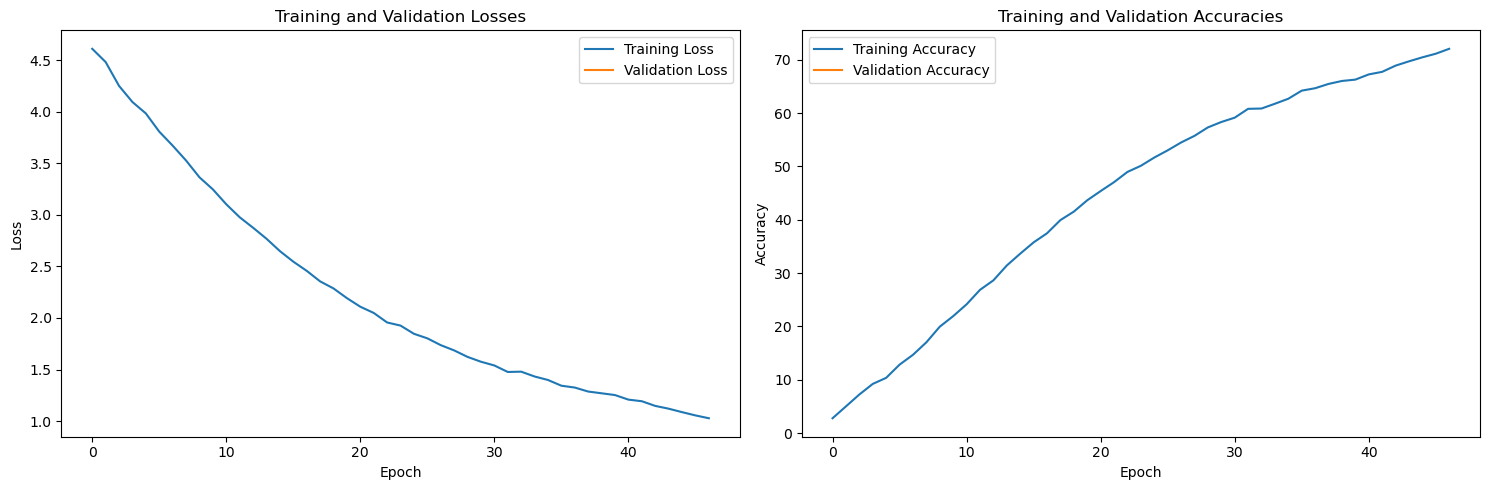

In [10]:
display_loss_and_accuracies(train_losses, train_acc, test_losses, test_acc)

## Visualize One Cycle Policy Implementation

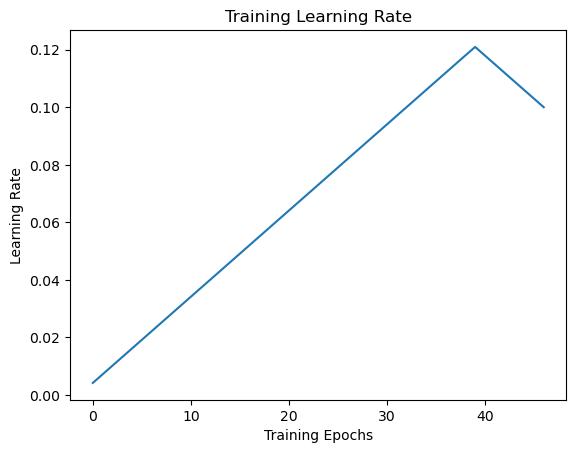

In [11]:
plt.plot(learning_rates)
plt.title("Training Learning Rate")
plt.xlabel("Training Epochs")
plt.ylabel("Learning Rate")
plt.show()

In [12]:
print(f"Training Config: {training_config}")
print(f"Model Config: {model_config}")
print(f"Data Config: {data_config}")


Training Config: TrainingConfig(batch_size=128, epochs=100, learning_rate=0.121, weight_decay=0.0001, mixed_precision=True, gradient_accumulation_steps=4, num_workers=4)
Model Config: ModelConfig(num_classes=100, dropout_rate=0.1)
Data Config: DataConfig(train_path='train.beton', val_path='val.beton', input_size=224)
